## Trading Strategy: Bollinger Bands with Keltner Channels
Bollinger Bands within Keltner Channels signals a Bollinger Squeeze - a potential reversal of volatility from low to high.

A squeeze occurs when upper BB lower than upper KC AND lower BB higher than lower KC.

Bullish scenario: price breakout from upper BB
<br>
Bearish scenario: price breakout from lower BB

#### Generate buy signal when:
- Closing price > Upper BB
- Upper BB < Upper KC for n consecutive number of periods prior (n = squeeze period)
- Lower BB > Lower KC for n consecutive number of periods prior

#### Generate sell signal when:
- Closing price < Lower BB
- Upper BB < Upper KC for n consecutive number of periods prior
- Lower BB > Lower KC for n consecutive number of periods prior

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import random

In [2]:
# Parameters tested in line with the following time period
start_date = "2012-01-01"
end_date = "2022-08-05"

# In days
n_bb = 20
n_kc = 20
std_lb = 20
atr_lb = 20
k_bb = 2
k_kc = 2
squeeze_time = 5

def get_data(ticker, start_date, end_date):
    
    """
    Scrape ticker data off Yahoo Finance.
    --------------
    Parameters
    
    ticker - str
        Denotes ticker symbol for a particular instrument.
        
    start_date - str
        Date from which data extraction begins (date given in form yyyy-mm-dd).
    
    end_date - str
        Date at which data extraction ends (date given in form yyyy-mm-dd).
    --------------
    Returns a pd.DataFrame with ticker data.
    
    """
    
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    
    # USDCNY on yf has a dodgy low on 11/07/2014, so make a manual adjustment based off Bloomberg's figure
    if ticker == "USDCNY=X":
        data.loc["2014-07-11", "Low"] = 6.2023
        
    # True Range
    data["TR"] = np.maximum.reduce((data["High"] - data["Low"], abs(data["High"] - data["Close"].shift(1)),
                      abs(data["Low"] - data["Close"].shift(1))))
    return data

# Obtain raw data for an instrument
USDCNY_raw = get_data("USDCNY=X", start_date, end_date)
USDCNY_raw

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,TR
Date,,,,,,,
2012-01-02,6.2840,6.2840,6.2840,6.2850,6.2850,0,NaN
2012-01-03,6.2840,6.2841,6.2840,6.2840,6.2840,0,0.0010
2012-01-04,6.2841,6.2960,6.2826,6.2970,6.2970,0,0.0134
2012-01-05,6.2826,6.3085,6.2826,6.2960,6.2960,0,0.0259
2012-01-06,6.2924,6.3150,6.2924,6.3085,6.3085,0,0.0226
...,...,...,...,...,...,...,...
2022-08-01,6.7432,6.7732,6.7419,6.7432,6.7432,0,0.0313
2022-08-02,6.7677,6.7809,6.7484,6.7677,6.7677,0,0.0377
2022-08-03,6.7518,6.7574,6.7430,6.7518,6.7518,0,0.0247


In [3]:
def get_bands(data, std_lookback, n=20, k=2):
    
    """
    Calculate upper and lower Bollinger Bands using an n-period simple moving average (SMA) and a standard 
    deviation k-multiple over a determined lookback period.
    --------------
    Parameters
    
    data - pd.DataFrame
        Security data (prices, trading volume etc.).
        
    std_lookback - int
        Lookback period length used to calculate standard deviation.
        
    n - int
        n-period SMA and standard deviation.
        
    k - int
        Upper/Lower Bollinger Band = SMA +/- kσ
    --------------
    Returns upper and lower Bollinger Bands over n periods.
    
    """
    
    adj_close_prices = data["Adj Close"].copy()
    
    n_sma = adj_close_prices.rolling(n).mean()
    std = adj_close_prices.rolling(std_lookback).std()
    
    upper_band = n_sma + k * std
    lower_band = n_sma - k * std
    
    return pd.DataFrame({f"SMA{n}": n_sma, "UB": upper_band, "LB": lower_band})

In [4]:
def get_channels(data, atr_lookback, n=20, k=2):
    
    """
    Calculate upper and lower Keltner Channels using an n-period exponential moving average (EMA) and an average 
    true range (ATR) k-multiple over a determined lookback period.
    --------------
    Parameters
    
    data - pd.DataFrame
        Security data (prices, trading volume, etc.).
        
    atr_lookback - int
        Lookback period length used to calculate average true range.
        
    n - int
        n-period EMA and ATR.
        
    k - int
        Upper/Lower Keltner Channel = EMA +/- k * ATR
    --------------
    Returns upper and lower Keltner Channels over n periods.
    
    """
    
    adj_close_prices = data["Adj Close"].copy()
    tr = data["TR"].copy()
    
    n_ema = adj_close_prices.ewm(span=n, adjust=False).mean()
    atr = tr.rolling(atr_lookback).mean()
    
    upper_channel = n_ema + k * atr
    lower_channel = n_ema - k * atr
    
    return pd.DataFrame({f"EMA{n}": n_ema, "UC": upper_channel, "LC": lower_channel})

In [5]:
def combined(ticker, start_date, end_date, time_periods):
    
    """
    Combine dataframes consisting of previously specified Bollinger Bands and Keltner Channels.
    --------------
    Parameters
    
    ticker - str
        Ticker name.
    
    start_date - str
        Date from which data extraction begins (date given in form yyyy-mm-dd).
    
    end_date - str
        Date at which data extraction ends (date given in form yyyy-mm-dd).
        
    time_periods - dict
        Key:value such that key = n_bb, n_kc etc.
    --------------
    Returns a pd.DataFrame with both Bollinger Band and Keltner Channel values.
    
    """  
    
    raw_data = get_data(ticker, start_date, end_date)
    raw_data = raw_data.drop(["Open", "High", "Low", "Close", "Volume"], axis=1)
    
    bb_data = get_bands(raw_data, time_periods["std_lb"], time_periods["n_bb"], time_periods["k_bb"])
    kc_data = get_channels(raw_data, time_periods["atr_lb"], time_periods["n_kc"], time_periods["k_kc"])
    
    combined = pd.concat([raw_data, bb_data, kc_data], axis=1)
    return combined

USDJPY_combined = combined("USDJPY=X", start_date, end_date, {"n_bb": n_bb, "n_kc": n_kc, "std_lb": std_lb, "atr_lb": atr_lb, "k_bb": k_bb, "k_kc": k_kc})
USDCNY_combined = combined("USDCNY=X", start_date, end_date, {"n_bb": n_bb, "n_kc": n_kc, "std_lb": std_lb, "atr_lb": atr_lb, "k_bb": k_bb, "k_kc": k_kc})

USDJPY_combined

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Adj Close,TR,SMA20,UB,LB,EMA20,UC,LC
Date,,,,,,,,
2012-01-02,77.019997,NaN,NaN,NaN,NaN,77.019997,NaN,NaN
2012-01-03,76.930000,0.366997,NaN,NaN,NaN,77.011426,NaN,NaN
2012-01-04,76.722000,0.330002,NaN,NaN,NaN,76.983861,NaN,NaN
2012-01-05,76.709999,0.459999,NaN,NaN,NaN,76.957779,NaN,NaN
2012-01-06,77.151001,0.598999,NaN,NaN,NaN,76.976181,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-08-01,133.406998,2.775009,136.705249,139.492765,133.917733,136.130038,139.174841,133.085235
2022-08-02,131.572006,2.977005,136.491850,140.093001,132.890698,135.695940,138.908243,132.483637
2022-08-03,133.378998,2.957993,136.384750,140.226824,132.542676,135.475279,138.884681,132.065876


In [6]:
def signals(data, squeeze_period):    
    
    """
    Generate buy/sell signals for an instrument using the Bollinger-Keltner squeeze strategy.
    --------------
    Parameters
    
    data - pd.DataFrame
        Instrument's data including bands and channels.
        
    squeeze_period - int
        Bollinger Band squeeze period length before breakout.
    --------------
    Returns a pd.DataFrame with adj. close figures, band/channel data, and signals.
    
    """
    
    combined_data = data.copy()
    combined_data["Buy"] = 0
    combined_data["Sell"] = 0
    
    # Row indices of the raw dataframe to determine possible buy signals
    pre_buy_idxes = np.where((combined_data["UB"] < combined_data["UC"]) 
                & (combined_data["LB"] > combined_data["LC"]))[0]
    # Row indices of the raw dataframe to determine possible sell signals
    pre_sell_idxes = np.where((combined_data["UB"] < combined_data["UC"]) 
                & (combined_data["LB"] > combined_data["LC"]))[0]
     
    at_buy_idxes = np.where((combined_data["Adj Close"] > combined_data["UB"])
                                    & (combined_data["UB"] < combined_data["UC"])
                                    & (combined_data["LB"] > combined_data["LC"]))[0]
    at_sell_idxes = np.where((combined_data["Adj Close"] < combined_data["LB"])
                                    & (combined_data["UB"] < combined_data["UC"])
                                    & (combined_data["LB"] > combined_data["LC"]))[0]
    
    buy_idxes = []
    sell_idxes = []
    
    # Buy index confirmed if breakout from upper BB is preceded directly by a squeeze period of length squeeze_period
    for i, buy_idx in enumerate(pre_buy_idxes):
        if buy_idx in at_buy_idxes and set([buy_idx - x for x in range(squeeze_period)]) == set(pre_buy_idxes[i:i-squeeze_period:-1]) and pre_buy_idxes[i:i-squeeze_period:-1].size != 0:
            buy_idxes.append(buy_idx)  
    
    # Sell index confirmed if breakout from lower BB is preceded directly by a squeeze period of length squeeze_period
    for j, sell_idx in enumerate(pre_sell_idxes):     
        if sell_idx in at_sell_idxes and set([sell_idx - y for y in range(squeeze_period)]) == set(pre_sell_idxes[j:j-squeeze_period:-1]) and pre_sell_idxes[j:j-squeeze_period:-1].size != 0:
            sell_idxes.append(sell_idx)    
    
    np_buy_idxes = np.array(buy_idxes)
    np_sell_idxes = np.array(sell_idxes)
    final_buy_idxes = []
    final_sell_idxes = []
    cur_buy_idx = 0
    cur_sell_idx = 0
    counter = 0
    
    # Loop ensures an alternating sequence of buy and sell signals (close position asap and go long/short accordingly afterwards)
    while len(buy_idxes) > 0 and len(sell_idxes) > 0:
        # First buy and sell signals will always be kept
        if counter == 0:
            cur_buy_idx = buy_idxes[counter]
            cur_sell_idx = sell_idxes[counter]
        else:
            if cur_buy_idx < cur_sell_idx:
                # Remove all sell indices smaller than the current buy index
                np_sell_idxes = np_sell_idxes[np_sell_idxes > cur_buy_idx]
                if np_sell_idxes.size > 0:
                    cur_sell_idx = np_sell_idxes[0]
                else:
                    break
                np_buy_idxes = np_buy_idxes[np_buy_idxes > cur_sell_idx]
                if np_buy_idxes.size > 0:
                    cur_buy_idx = np_buy_idxes[0]
                else:
                    break
            elif cur_buy_idx > cur_sell_idx:
                # Remove all buy indices smaller than the current sell index
                np_buy_idxes = np_buy_idxes[np_buy_idxes > cur_sell_idx]
                if np_buy_idxes.size > 0:  
                    cur_buy_idx = np_buy_idxes[0]
                else:
                    break
                np_sell_idxes = np_sell_idxes[np_sell_idxes > cur_buy_idx]
                if np_sell_idxes.size > 0:
                    cur_sell_idx = np_sell_idxes[0]
                else:
                    break
                
        final_buy_idxes.append(cur_buy_idx)
        final_sell_idxes.append(cur_sell_idx)
        counter += 1
    
    combined_data.iloc[final_buy_idxes, combined_data.columns.get_loc("Buy")] = 1
    combined_data.iloc[final_sell_idxes, combined_data.columns.get_loc("Sell")] = 1
    
    return combined_data
        
    
USDCNY_signals = signals(USDCNY_combined, squeeze_time)
USDJPY_signals = signals(USDJPY_combined, squeeze_time)
USDCNY_signals

,Adj Close,TR,SMA20,UB,LB,EMA20,UC,LC,Buy,Sell
Date,,,,,,,,,,
2012-01-02,6.2850,NaN,NaN,NaN,NaN,6.285000,NaN,NaN,0,0
2012-01-03,6.2840,0.0010,NaN,NaN,NaN,6.284905,NaN,NaN,0,0
2012-01-04,6.2970,0.0134,NaN,NaN,NaN,6.286057,NaN,NaN,0,0
2012-01-05,6.2960,0.0259,NaN,NaN,NaN,6.287004,NaN,NaN,0,0
2012-01-06,6.3085,0.0226,NaN,NaN,NaN,6.289051,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,6.7432,0.0313,6.735185,6.781559,6.688811,6.737528,6.796348,6.678708,0,0
2022-08-02,6.7677,0.0377,6.738640,6.783819,6.693461,6.740401,6.799121,6.681682,0,0
2022-08-03,6.7518,0.0247,6.740290,6.784824,6.695756,6.741487,6.800467,6.682507,0,0


In [7]:
def plot(ticker, signal_data):
    
    """
    Plot a graph containing an instrument's adjusted close price, Bollinger Bands (BB), and Keltner Channels (KC).
    --------------
    Parameters
    
    ticker - str
        Instrument ticker name.
    
    signal_data - pd.DataFrame
        DataFrame containing details of adjusted close prices, lower/upper BBs, and lower/upper KCs.
    --------------
    Outputs graph; returns None.
    
    """
    
    plt.figure(figsize=(13, 7), dpi=300)
    
    plt.plot(signal_data["Adj Close"], label="Adj. Close", linewidth=2, color="blue")

    # Plotting Bollinger Bands
    plt.plot(signal_data["UB"], label="Upper BB", linestyle="dashed", linewidth=1.5, color="black", alpha=1)
    plt.plot(signal_data["LB"], label="Lower BB", linestyle="dashed", linewidth=1.5, color="black", alpha=1)

    # Plotting Keltner Channels
    plt.plot(signal_data["UC"], label="Upper KC", linestyle="dashed", linewidth=1.5, color="green", alpha=1)
    plt.plot(signal_data["LC"], label="Lower KC", linestyle="dashed", linewidth=1.5, color="green", alpha=1)
    
    # Plot buy signals
    plt.plot(signal_data.loc[signal_data["Buy"] == 1, "Adj Close"], "^", markersize=10, color="g", label="Buy")

    # Plot sell signals
    plt.plot(signal_data.loc[signal_data["Sell"] == 1, "Adj Close"], "v", markersize=10, color="r", label="Sell")

    plt.legend(loc="upper left", prop={"size": 10})

    plt.title(f"{ticker} with Bollinger Bands + Keltner Channels", y=1.05)
    plt.xlabel(f"{start_date} to {end_date}", fontsize=15)
    plt.ylabel(f"{ticker}", fontsize=15)
    plt.grid()

    plt.show()

In [8]:
def stats(ticker, data, notional=100):
    
    """
    Calculate various statistics for an instrument traded with the Bollinger-Keltner squeeze strategy:
    cumulative PnL, annualised return, return standard deviation, Sharpe ratio, number of +/-ve signals,
    and average PnL per +/-ve signal.
    --------------
    Parameters
    
    ticker - str
        Denotes ticker symbol for a particular instrument.
    
    data - pd.DataFrame
        Instrument details including buy/sell signals.
        
    notional - int
        Notional amount used to calculate PnL.
    --------------
    Returns cumulative PnL and annualised return respectively as a tuple.
    
    """
    
    data = data.copy()
    
    # Create "Daily PnL" column
    data.loc[data.index >= data[(data["Buy"] != 0) | ((data["Sell"]) != 0)].index[0], "Daily PnL"] \
    = notional * ((data["Adj Close"].shift(-1)-data["Adj Close"])/data["Adj Close"].shift(-1))
    
    # 1 when long, -1 when short
    position = 0
    
    # Determine trade position after each period because long/short positions affect Daily PnL calculations
    for i, row in enumerate(data.itertuples()):
        # Buy signal => position = 1, sell signal => position = -1
        if row.Buy == 1 or row.Sell == 1:
            position = row.Buy - row.Sell
        if position != 0:    
            data.iloc[i, data.columns.get_loc("Daily PnL")] *= position
            
    data["Cum PnL"] = data["Daily PnL"].cumsum()
    # Final cumulative PnL in the last row of "data" that is not a NaN value
    cum_pnl = data.loc[data["Cum PnL"].last_valid_index(), "Cum PnL"]
    
    num_years = (data.index[-1]-data.index[0]).days / 365
    # notional * (1+ann_ret)**num_years = notional + cum_pnl
    ann_ret = ((notional+cum_pnl)/notional)**(1/num_years) - 1
    
    # Assume 250 trading days in a year
    ann_std = (data["Daily PnL"].std() * 250**0.5) / notional
    ann_sr = ann_ret / ann_std
   
    buy_idxes = np.where(data["Buy"] == 1)[0]
    sell_idxes = np.where(data["Sell"] == 1)[0]
    combined_idxes = np.sort(np.concatenate((buy_idxes, sell_idxes)))
   
    sig_cum_pnls = data.iloc[combined_idxes, data.columns.get_loc("Cum PnL")]
    np_cum_pnls_diffs = np.diff(sig_cum_pnls.to_numpy())
    pos_sigs = (np_cum_pnls_diffs > 0).sum()
    neg_sigs = (np_cum_pnls_diffs <= 0).sum()
    mean_pnl_pos = np_cum_pnls_diffs[np_cum_pnls_diffs > 0].mean()
    mean_pnl_neg = np_cum_pnls_diffs[np_cum_pnls_diffs <= 0].mean()
    #median_pnl_pos = np.median(np_cum_pnls_diffs[np_cum_pnls_diffs > 0])
    #median_pnl_neg = np.median(np_cum_pnls_diffs[np_cum_pnls_diffs <= 0])
    
    final_pnl = data.loc[data["Cum PnL"].last_valid_index(), "Cum PnL"] \
    - data.iloc[combined_idxes[-1], data.columns.get_loc("Cum PnL")]
    if final_pnl > 0:
        pos_sigs += 1
    elif final_pnl <= 0:
        neg_sigs += 1
    
    stats = pd.DataFrame({"AUM ($)": notional,  
                          "Cum PnL ($)": round(cum_pnl, 2), 
                          "Annualised Return (%)": round(ann_ret*100, 2), 
                          "Return StDev. (%)": round(ann_std*100, 2), 
                          "Sharpe Ratio": round(ann_sr, 2),
                          "# +ve Signals": pos_sigs, 
                          "# -ve Signals": neg_sigs,
                          "+ve Signal Mean PnL": round(mean_pnl_pos, 2),
                          "-ve Signal Mean PnL": round(mean_pnl_neg, 2),
                          }, index=[ticker])
    # Display number of +/- signals as an integer rather than a float
    stats = stats.astype({"+ve Signal Mean PnL": str, "-ve Signal Mean PnL": str})
    stats.index.name = "Statistics"
    stats = stats.T
        
    return stats, data
    

USDCNY_stats = stats("USDCNY", signals(combined("USDCNY=X", start_date, end_date, 
                       {"n_bb": 25, "n_kc": 30, "std_lb": 25, "atr_lb": 42, "k_bb": 2, "k_kc": 2}), 5),
      100)

USDJPY_stats = stats("USDJPY", signals(combined("USDJPY=X", start_date, end_date, 
                       {"n_bb": 22, "n_kc": 27, "std_lb": 22, "atr_lb": 27, "k_bb": 2, "k_kc": 2}), 5),
      100)

pd.concat((USDCNY_stats[0], USDJPY_stats[0]), axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Statistics,USDCNY,USDJPY
AUM ($),100,100
Cum PnL ($),39.82,83.21
Annualised Return (%),3.21,5.88
Return StDev. (%),3.69,8.66
Sharpe Ratio,0.87,0.68
# +ve Signals,15,13
# -ve Signals,12,9
+ve Signal Mean PnL,3.33,6.42
-ve Signal Mean PnL,-1.06,-1.33


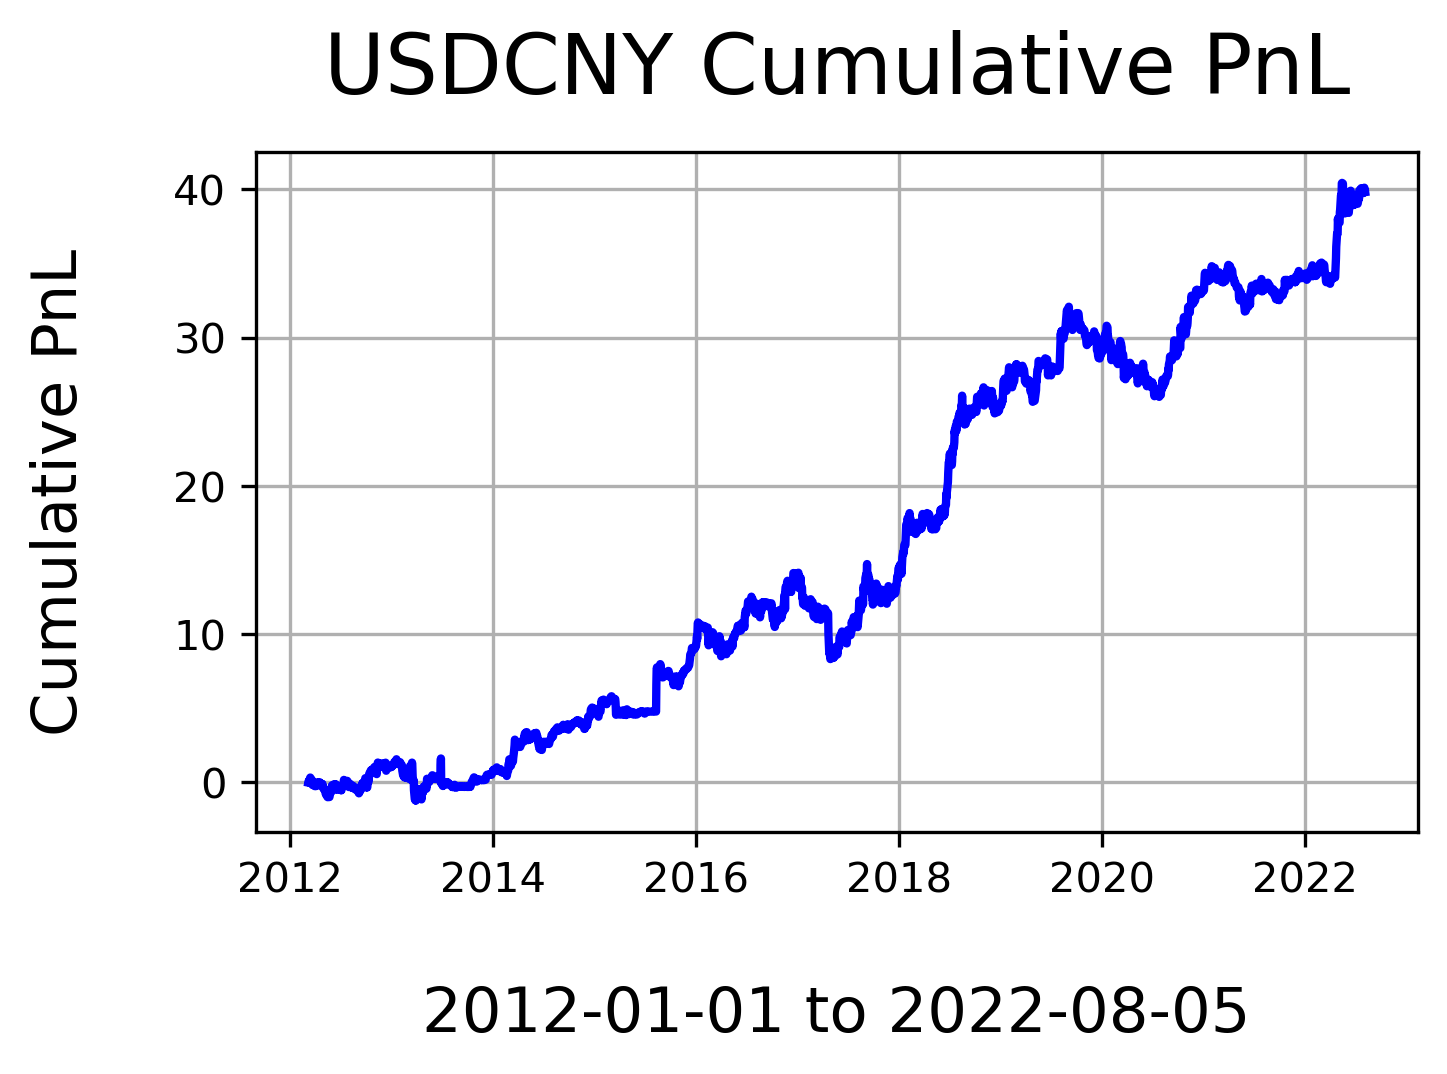

In [9]:
def pnl_plot(ticker, signal_data):
    
    """
    Plot a graph containing an instrument's adjusted close price, Bollinger Bands (BB), and Keltner Channels (KC).
    --------------
    Parameters
    
    ticker - str
        Instrument ticker name.
    
    signal_data - pd.DataFrame
        DataFrame containing details of adjusted close prices, lower/upper BBs, and lower/upper KCs.
    --------------
    Outputs graph; returns None.
    
    """
    
    plt.figure(figsize=(5, 3), dpi=300)
    
    plt.plot(signal_data["Cum PnL"], label="Cum PnL", linewidth=2, color="blue")

    plt.title(f"{ticker} Cumulative PnL", fontsize=20, y=1.05)
    plt.xlabel(f"{start_date} to {end_date}", fontsize=15, labelpad=20)
    plt.ylabel("Cumulative PnL", fontsize=15, labelpad=20)
    plt.grid()
    
    #plt.savefig("USDCNY.png", bbox_inches="tight", pad_inches=0.5)

    plt.show()

    
USDCNY_pnl = pnl_plot("USDCNY", USDCNY_stats[1])

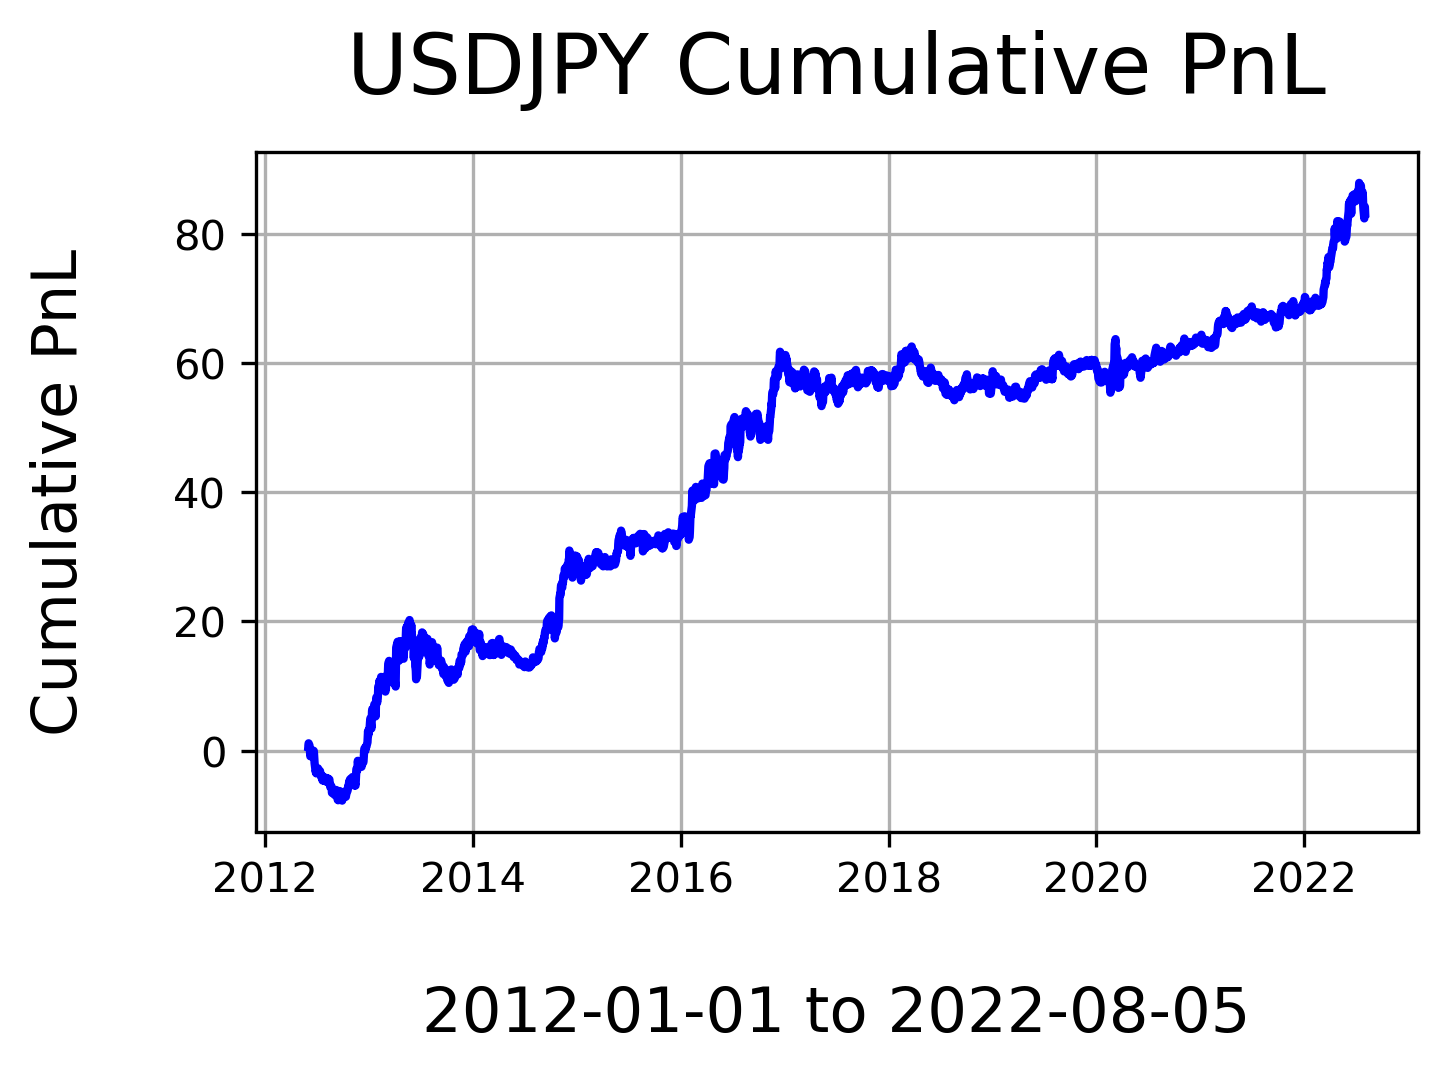

In [10]:
USDJPY_pnl = pnl_plot("USDJPY", USDJPY_stats[1])

In [11]:
ticker_list = ["USDJPY=X"]
num_subplots = len(ticker_list)

if (num_subplots**0.5).is_integer():
    num_cols = int(num_subplots**0.5)
else:
    num_cols = int(num_subplots**0.5) + 1
if (num_subplots/num_cols).is_integer():
    num_rows = int(num_subplots/num_cols)
else:
    num_rows = num_subplots//num_cols + 1
    

def multiple_plot(signal_data, num_rows=1, num_cols=1):
    
    """
    Plot several graphs containing instruments' adjusted close price, Bollinger Bands (BB), and Keltner Channels (KC).
    --------------
    Parameters
    
    signal_data - dict
        Key:value such that key = ticker name, value = signal data in a pd.DataFrame.
        
    num_rows - int
        Number of rows in ax.
        
    num_cols - int
        Number of columns in ax.
    --------------
    Outputs graphs; returns None.
    
    """
    
    plt.rcParams.update(plt.rcParamsDefault)
    
    # Fixes wrong years for graph x axis but no idea why?
    pd.plotting.plot_params = {'x_compat': True}
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5, 3), dpi=300, squeeze=False)
    plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.5, wspace=0.2)
    
    for ticker, df in signal_data.items():
        for x in range(num_rows):
            for y in range(num_cols):
                for ticker, ax in zip(signal_data.keys(), axs.ravel()):
                    df = signal_data[ticker]
                    df["Adj Close"].plot(ax=ax, label="Adj. Close", linewidth=2, color="blue", alpha=1)
                    df["UB"].plot(ax=ax, label="Upper BB", linestyle="dashed", linewidth=1.5, color="black", alpha=1)
                    df["LB"].plot(ax=ax, label="Lower BB", linestyle="dashed", linewidth=1.5, color="black", alpha=1)
                    df["UC"].plot(ax=ax, label="Upper KC", linestyle="dashed", linewidth=1.5, color="green", alpha=1)
                    df["LC"].plot(ax=ax, label="Lower KC", linestyle="dashed", linewidth=1.5, color="green", alpha=1)
                    if df.loc[df["Buy"] == 1].empty:
                        pass
                    else:
                        df.loc[df["Buy"] == 1, "Adj Close"].plot(ax=ax, marker="^", markersize=10, color="g", label="Buy", linestyle="None")
                    if df.loc[df["Sell"] == 1].empty:
                        pass
                    else:
                        df.loc[df["Sell"] == 1, "Adj Close"].plot(ax=ax, marker="v", markersize=10, color="r", label="Sell", linestyle="None")

                    # Only use when plotting a single axis
                    ax.legend(loc="upper left", prop={"size": 7})

                    # Only use this for forex pairs because yf forex tickers end in "=X"
                    ax.set_title(ticker[:-2].upper(), fontsize=17)
                    
                    #ax.set_title(ticker.upper(), fontsize=17)
                    ax.set_xlabel("")
                    #ax.tick_params("x", labelrotation=90)
                    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
                    ax.margins(x=0)
                    ax.grid()
                    
    #fig.savefig("USDJPY.png", bbox_inches="tight", pad_inches=0.5)
    #fig.tight_layout(rect=[0, 0.3, 1, 1])
    
                
#multiple_plot({"USDJPY": USDJPY_signals, "USDCNY": USDCNY_signals}, 2, 2)       

[*********************100%***********************]  1 of 1 completed


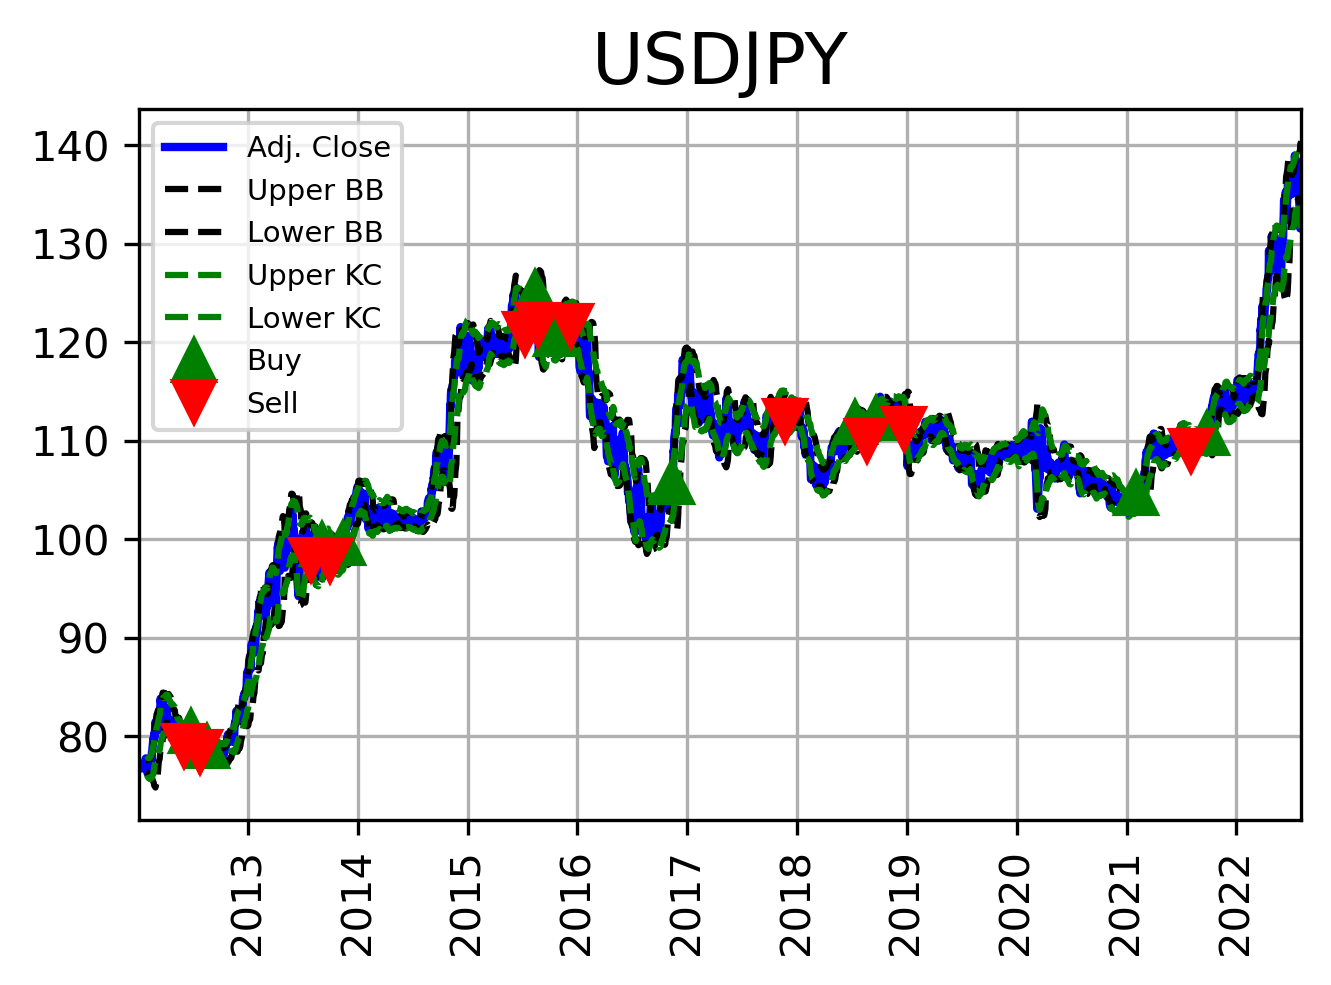

In [12]:
def grapher(tickers, start_date, end_date, time_periods, squeeze_period, num_rows=1, num_cols=1):
    
    """
    Plot graphs given tickers.
    --------------
    Parameters
    
    tickers - list
        Instrument ticker names.
        
    time_periods - dict
        Key:value such that key = n_bb, n_kc etc.
    
    squeeze_period - int
        Bollinger Band squeeze period length before breakout.
    
    num_rows - int
        Number of graphs in each column.
        
    num_cols - int
        Number of graphs in row.
    --------------
    Outputs graphs; returns None.
    
    """
    
    ticker_data = {}
    
    # Set up ticker_data such that key - ticker name, value - ticker dataframe
    for ticker in tickers: 
        ticker_df = signals(combined(ticker, start_date, end_date, time_periods), squeeze_period)
        ticker_data[ticker] = ticker_df
        
    multiple_plot(ticker_data, num_rows, num_cols)


grapher(ticker_list, start_date, end_date, {"n_bb": n_bb, "n_kc": n_kc, "std_lb": std_lb, "atr_lb": atr_lb, "k_bb": k_bb, "k_kc": k_kc},
        squeeze_time, num_rows, num_cols)